# Drinking age - Bayesian analysis

This example uses the regression discontinuity design to make claims about the causal effects of the minimum legal drinking age (21 in the USA) upon all cause mortality rates. The dataset is from a study by {cite:t}`carpenter2009effect`.

In [1]:
import arviz as az
import matplotlib.pyplot as plt

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

Load and process data.

In [3]:
df = (
    cp.load_data("drinking")
    .rename(columns={"agecell": "age"})
    .assign(treated=lambda df_: df_.age > 21)
)

## Main effects model

First we will examine a simple 'main effects' model. Here, the expected death rate (in units of deaths/1000 people/year) for a given age $a$ (with monthly resolution), is modelled with an intercept term $\beta_0$, a treatment effect $\beta_1$ and an effect of age $\beta_2$.

$$
\mu(a) = \beta_0 + \beta_1 t(a) + \beta_2  a
$$

The term $t(a)$ describes whether 'treatment' has been applied. In this example it simply describes whether a give age $a$ is over the minimum legal drinking age of 21:

$$
\begin{align}
t(a) = 
    \begin{cases} 
        1 & \text{if $a \ge 21$} \\
        0 & \text{if $a < 21$} 
    \end{cases}
\end{align}
$$

To be clear, $\beta_2  a$ describes a linear trend of how expected mortality rate changes with age. The coefficient $\beta_0$ is the intercept of this linear trend (at $a=0$). This leaves $\beta_1 t(a)$ which we can understand as modelling the discontinuity of the linear trend around the age threshold.  

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not neccessary. We use it here so that the results are reproducible.
:::

In [4]:
result = cp.pymc_experiments.RegressionDiscontinuity(
    df,
    formula="all ~ 1 + age + treated",
    running_variable_name="age",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
    treatment_threshold=21,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


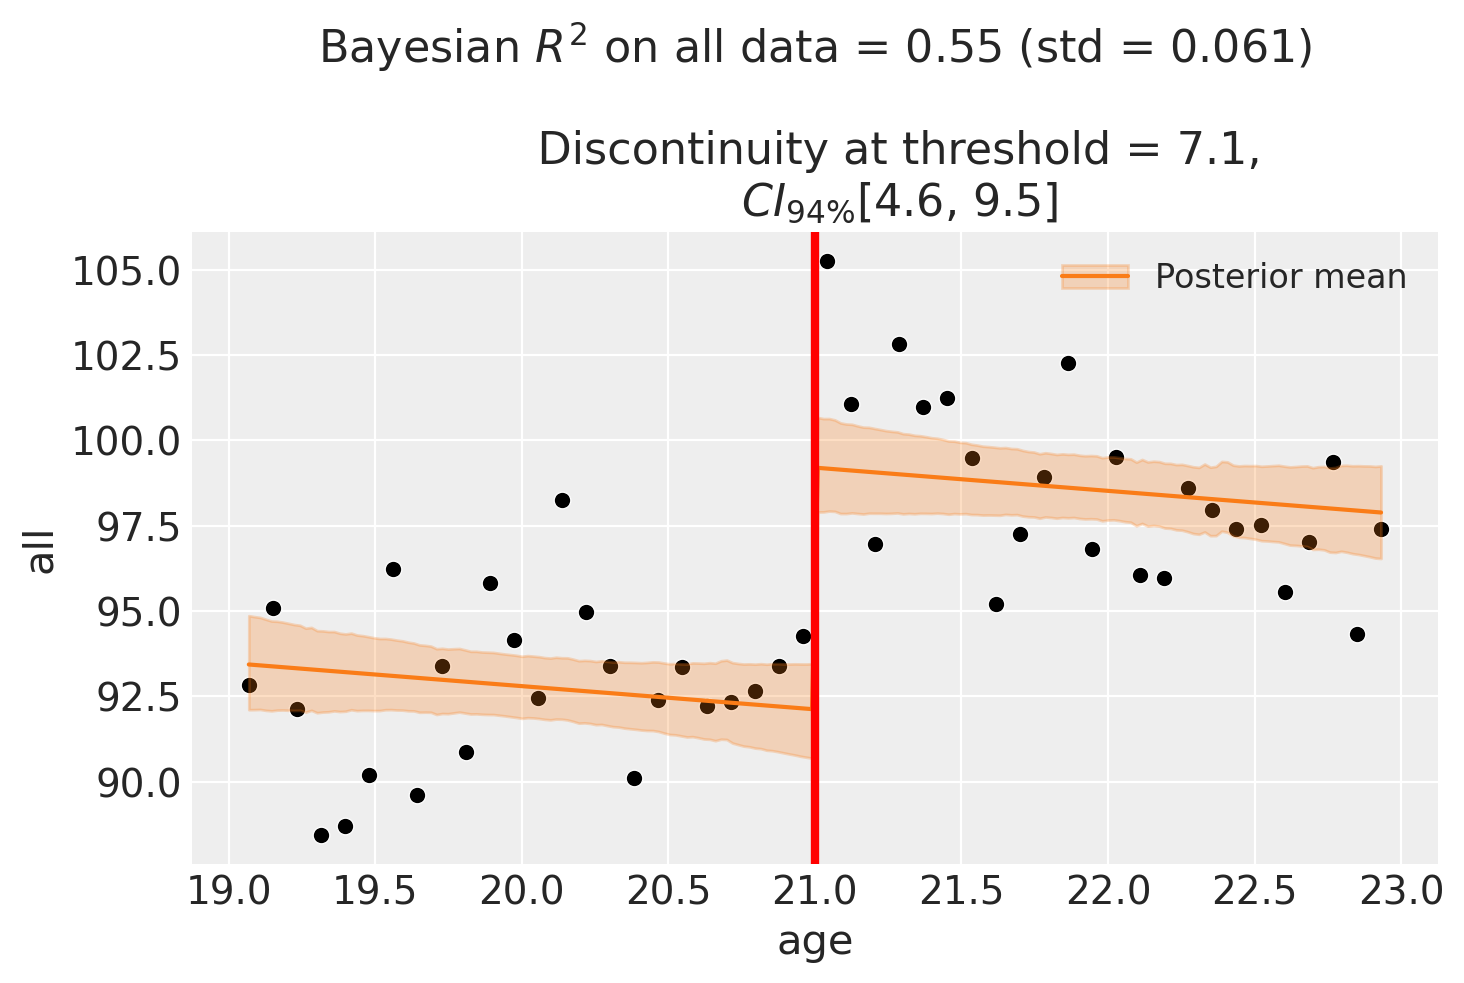

In [5]:
fig, ax = result.plot()

And let's grab the text summary of the results.

In [6]:
result.summary()

============================Regression Discontinuity============================
Formula: all ~ 1 + age + treated
Running variable: age
Threshold on running variable: 21

Results:
Discontinuity at threshold = 7.1
Model coefficients:
Intercept                     106, 94% HDI [84, 128]
treated[T.True]               7.1, 94% HDI [4.6, 9.5]
age                           -0.68, 94% HDI [-1.7, 0.41]
sigma                         2.4, 94% HDI [2, 2.9]


In this main effects model, the size of the causal effect is equal to our posterior estimate of $\beta_1$. Let's plot the parameter estimates (left) and zoom in on the posterior distribution for the main effect of treatment (right).

/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


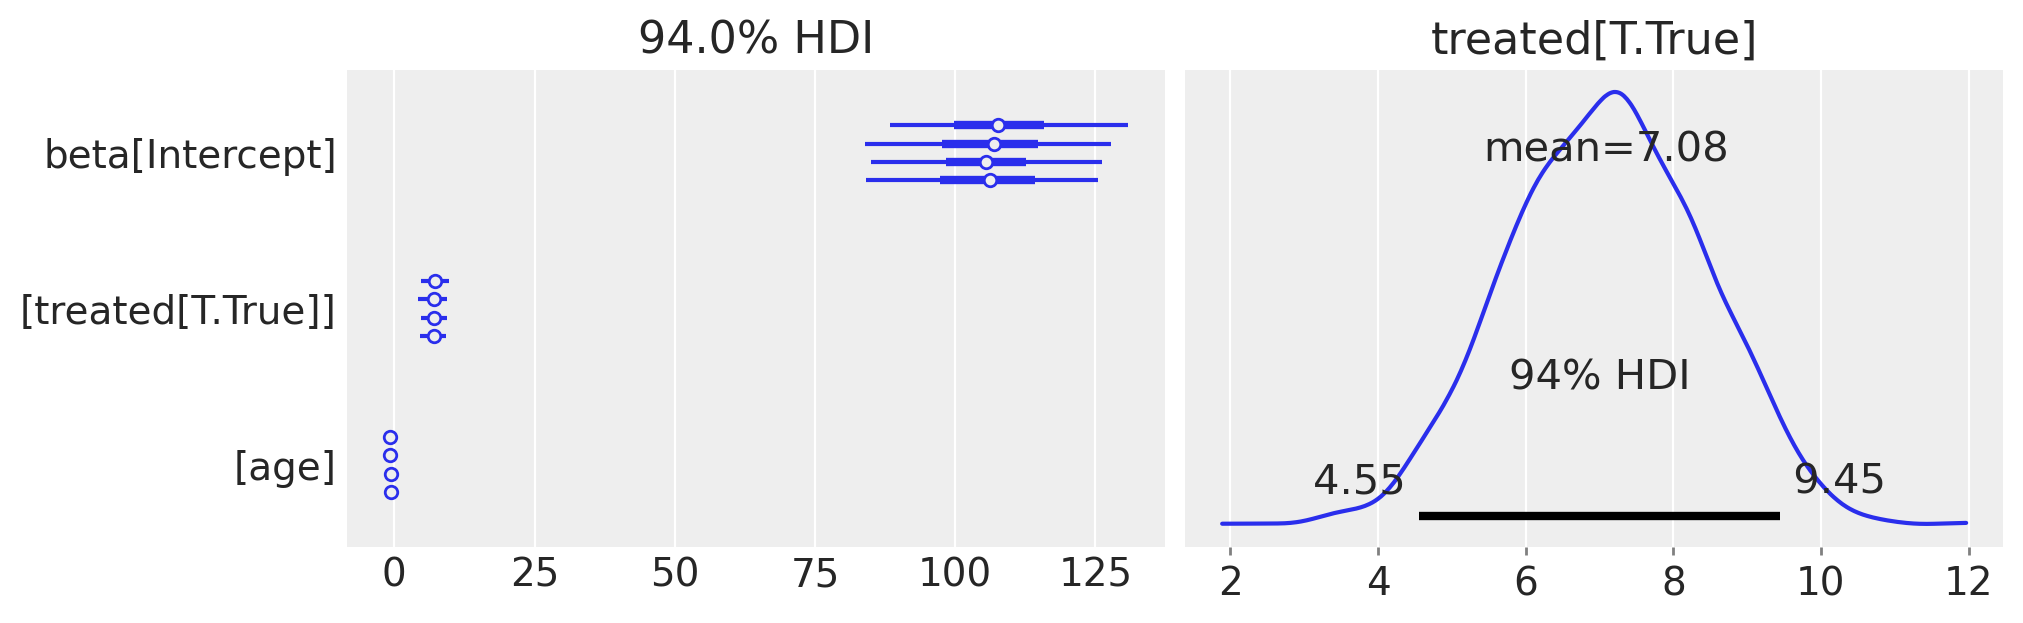

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

az.plot_forest(result.idata.posterior, var_names="beta", ax=ax[0])
az.plot_posterior(
    result.idata.posterior.beta.sel(coeffs="treated[T.True]"),
    round_to=3,
    ax=ax[1],
)

ax[1].set(title="treated[T.True]");

We can see that this matches up (nearly exactly) with the "discontinuity at threshold" figures in the first results figure.

It is not exactly the same because we actually manually calculate the discontinuity at threshold. The reason for this is because in anything but the simplest model, the discontinuity at threshold is not simply equal to this parameter. In order to understand this, let's look at the marginally more complex model where we incorporate an interaction term.

## Interaction model

We add an interaction term by changing our formula to `all ~ 1 + age + treated + age:treated`. This now changes the statistical model to :

$$
\mu(a) = \beta_0 + \beta_1 t(a) + \beta_2  a + \beta_3 t(a) \cdot a
$$

This model is now more complex in that it can _allow_ for the trend in mortality rate to vary before versus after the age of 21 _if the data suggest it_. If it is not clear already, it will be clear from the next results figure that the discrepancy at threshold is no longer equal to the $\beta_1$ coefficient. Let's run the model and see.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


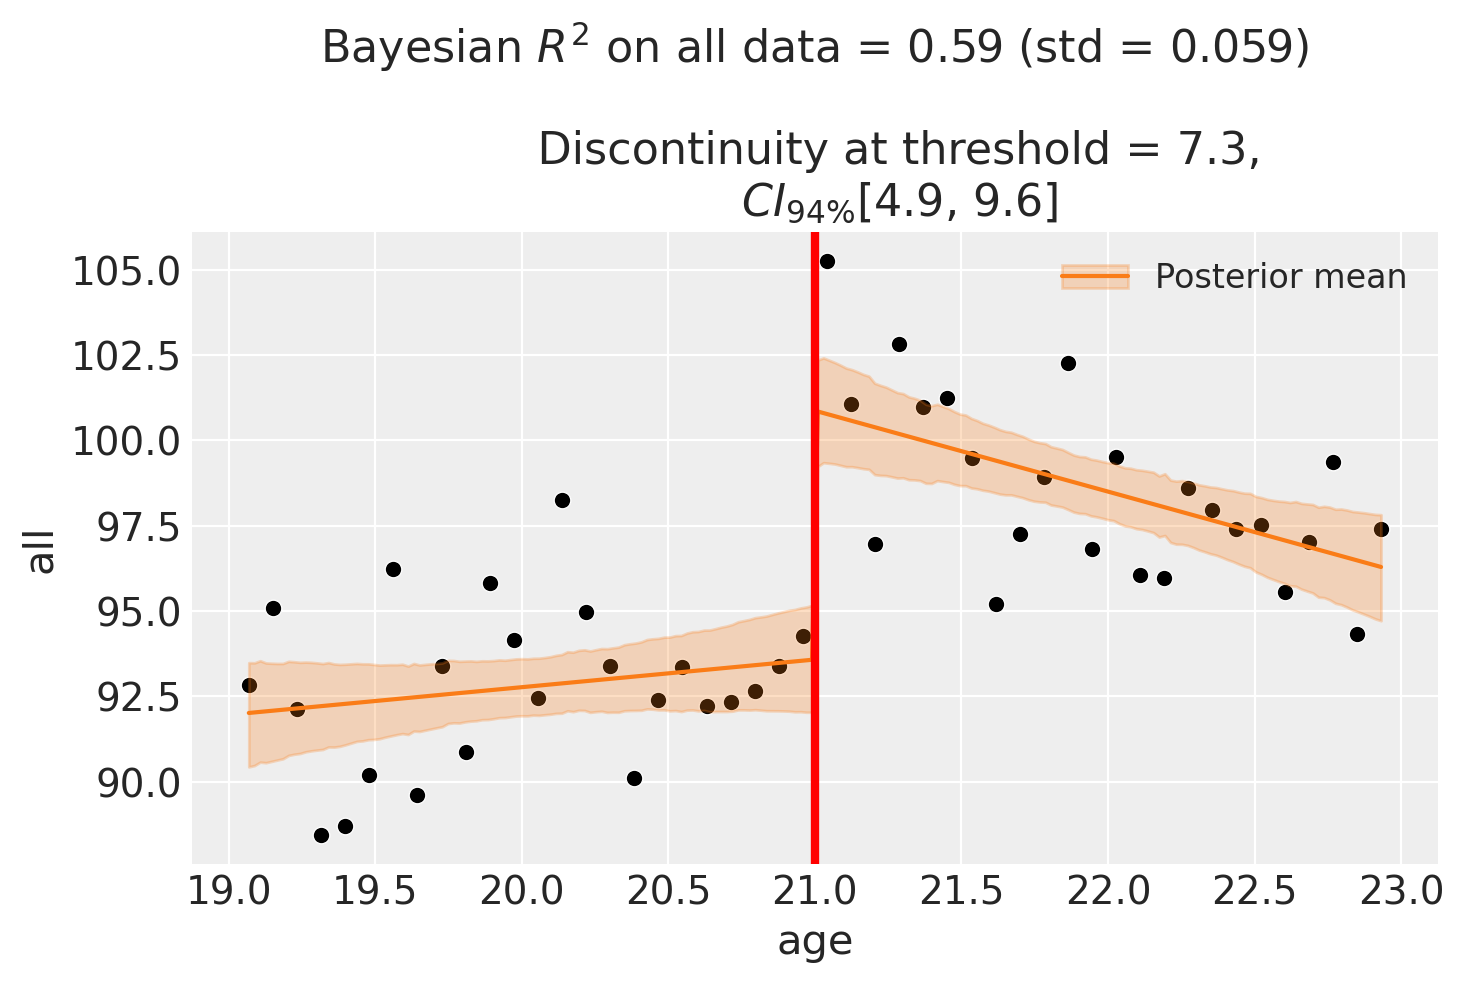

In [8]:
result2 = cp.pymc_experiments.RegressionDiscontinuity(
    df,
    formula="all ~ 1 + age + treated + age:treated",
    running_variable_name="age",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=21,
)

fig, ax = result2.plot()

We can now see that by adding an interaction term, the parameter estimates are now much changed, and the estimated discontinuity at threshold is no longer simply given by the $\beta_1$ parameter. To confirm this, we can check the estimate of $\beta_1$ (which corresponds to the `treated[T.True]` coefficient).

/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


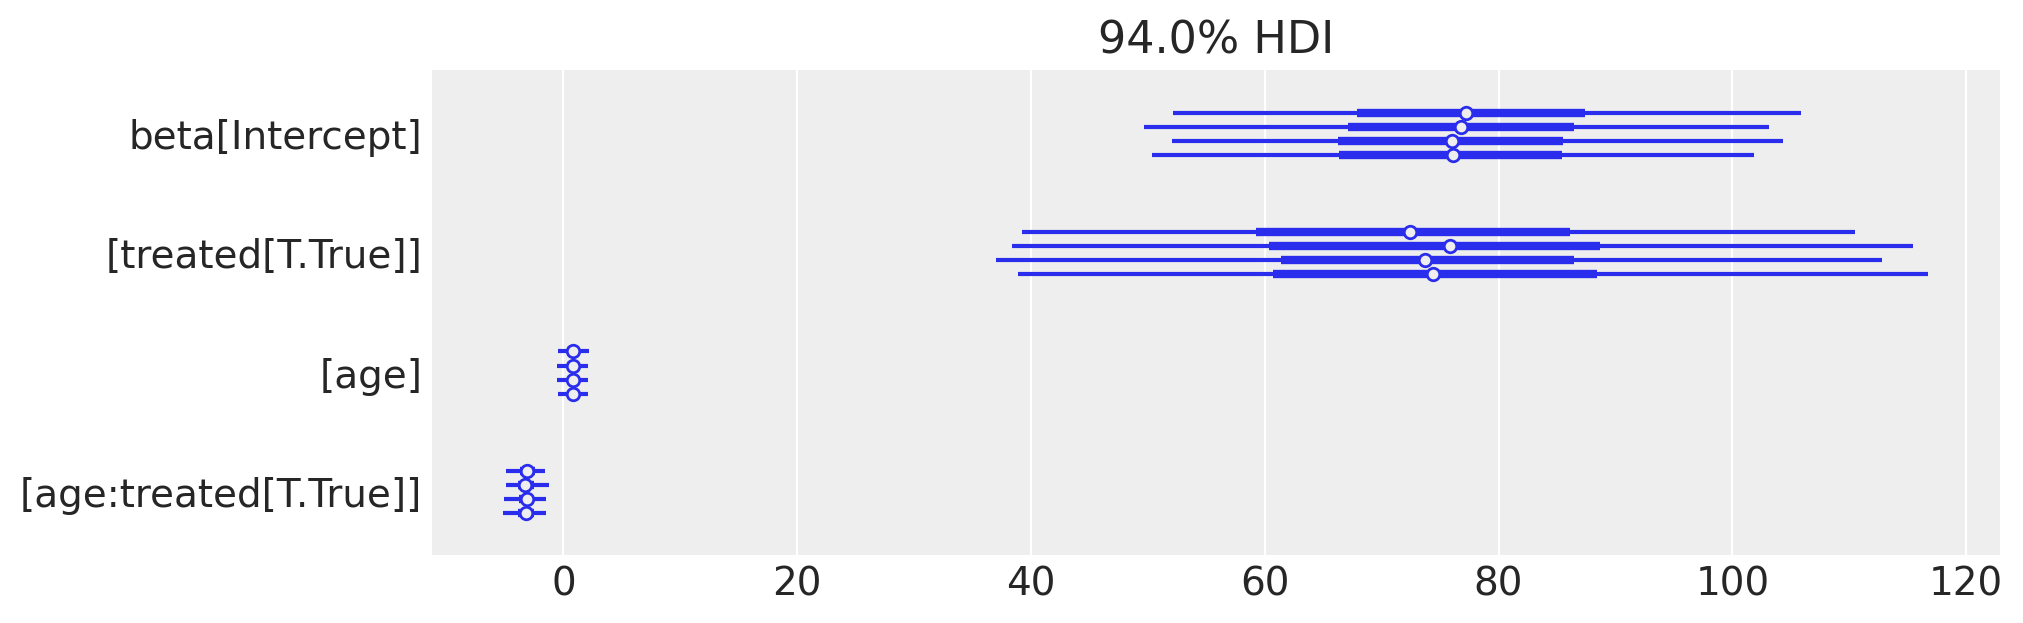

In [9]:
az.plot_forest(result2.idata.posterior, var_names="beta", figsize=(10, 3));

We can see that this estimate is now wildly off the desired "discontinuity at threshold" value. It is for this reason that `CausalPy` manually calculates the "discontinuity at threshold" by evaluating the difference in predicted outcome values slightly above versus slightly below the treatment threshold.

## Centering the running variable on the treatment threshold

Another practice to deal with this is to centre the running variable on the threhsold such that the threshold (minimum legal drinking age) is now at zero. This also makes the parameters more interpretable.

In [10]:
df["age"] = df["age"] - 21

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


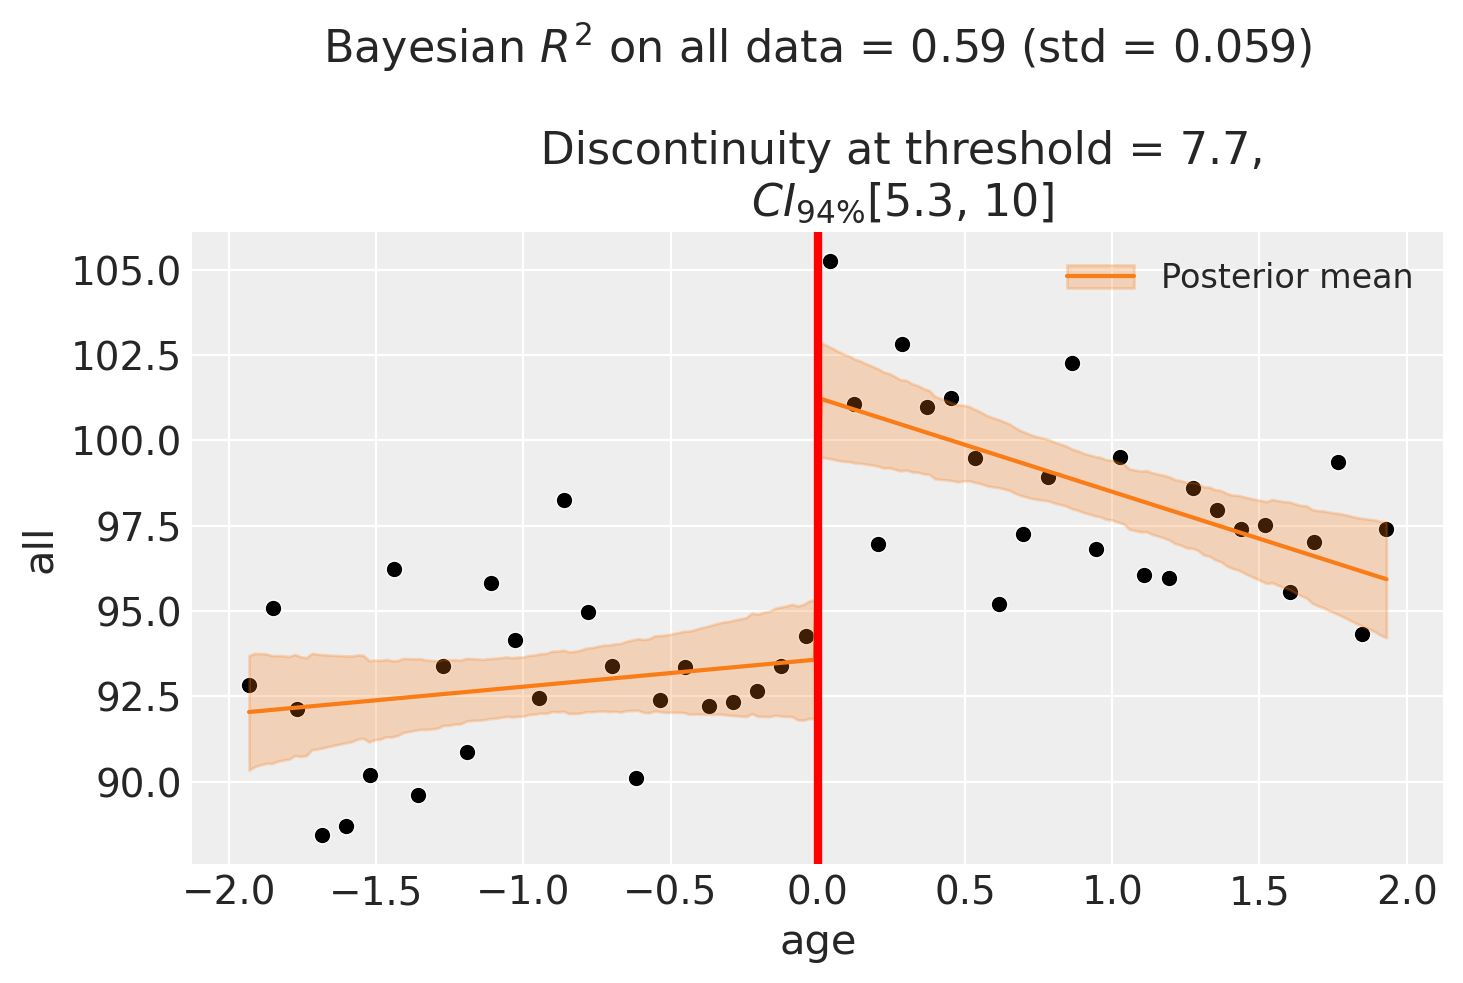

In [11]:
result3 = cp.pymc_experiments.RegressionDiscontinuity(
    df,
    formula="all ~ 1 + age + treated + age:treated",
    running_variable_name="age",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0,
)

fig, ax = result3.plot()

/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


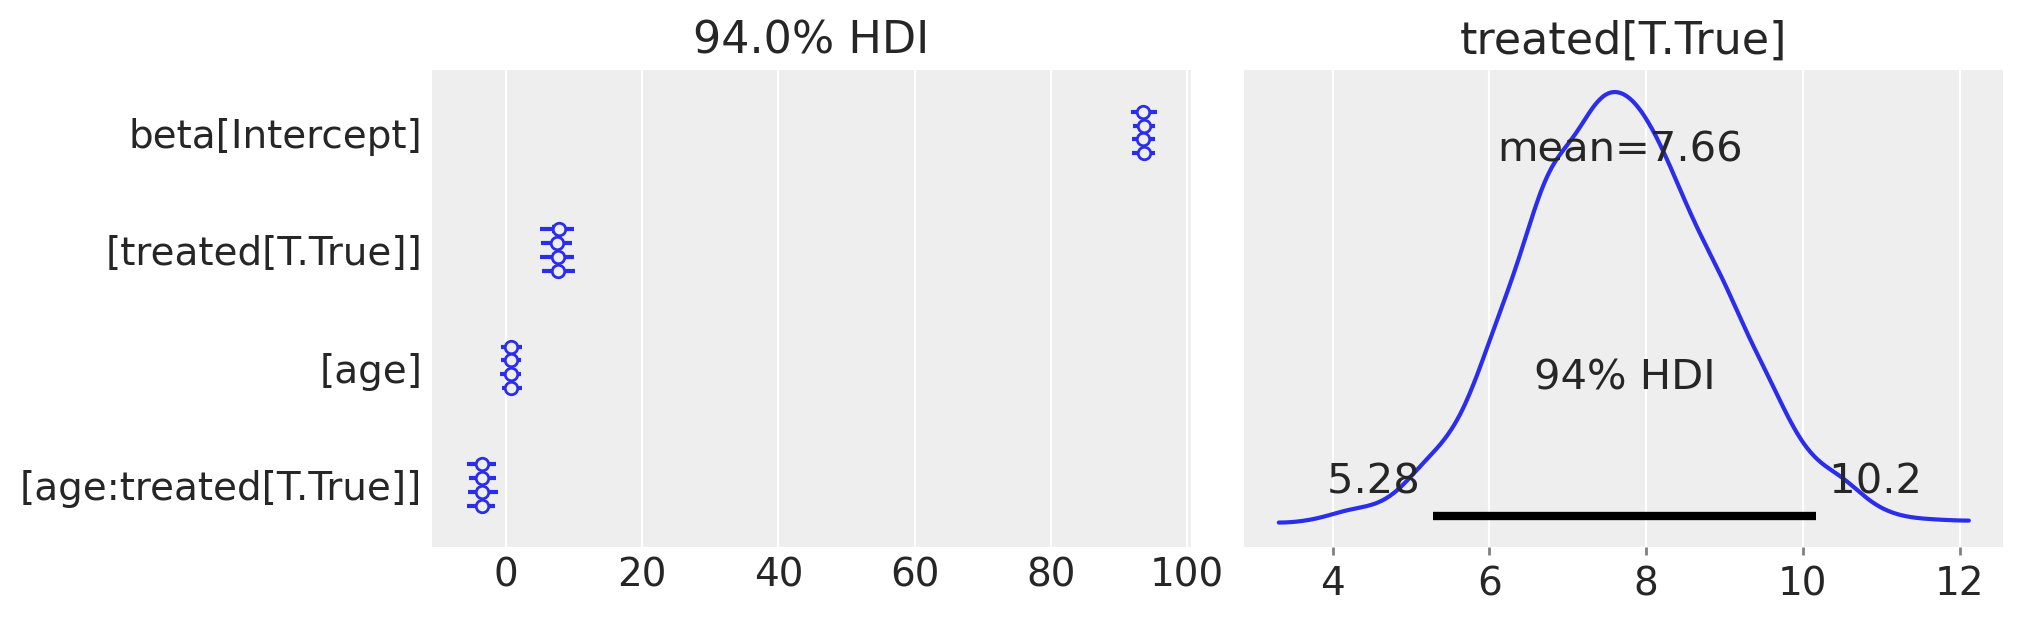

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

az.plot_forest(result3.idata.posterior, var_names="beta", ax=ax[0])
az.plot_posterior(
    result3.idata.posterior.beta.sel(coeffs="treated[T.True]"),
    round_to=3,
    ax=ax[1],
)

ax[1].set(title="treated[T.True]");

## References
:::{bibliography}
:filter: docname in docnames
:::